## **Enhancing LLM inferencing with RAG and fine-tuned LLMs**
### **Generative AI Workshop, AI-ML Systems Conference - 2023, Bengaluru**
---
Anupam Purwar & Abhinav Kimothi

Agenda -

1. Inference OpenAI and Open Source LLMs
2. Discuss the challenges with LLMs
3. Demonstrate Retrieval Augmented Generation (RAG)
4. Fine tune OpenAI models
5. Fully fine-tune an open source LLM

#### just some notebook formatting

In [ ]:
### Run Only when using colab for formatting table display
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
### Run Only when using colab for formatting table display
%load_ext google.colab.data_table

# Installing Dependencies

#### Importing Libraries

**openai** - To inference OpenAI's GPT series of models and fine-tune them.

**text_generation** - To inference an open source model on Hugging Face (Falcon 7B Instruct)

**gradio** - To build an interface.

**pypdf2** - To read PDF documents for RAG.

**tiktoken** - To count the number of tokens in a prompt.

**requests** - For making API requests

**Beautiful Soup** - To extract a webpage for RAG

**transformers** - To access models from HuggingFace

**datasets** - To access HuggingFace Datasets

**langchain** - Framework to use for RAG

**faiss-cpu** - To save and search embeddings for RAG



In [ ]:
import os
print(os.getcwd())

In [ ]:
%pip install -r ../requirements.txt

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import openai
import pandas as pd
import gradio as gr
import requests, json
from text_generation import Client
from bs4 import BeautifulSoup
import PyPDF2
import io
import tiktoken
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from datasets import Dataset
import torch
from configparser import ConfigParser

from accelerate import Accelerator


#### **OpenAI API Key**



OpenAI models are proprietary. In order to access them, you have to create an account and get an api key. You can get an api key [here](https://platform.openai.com/account/api-keys)

In [9]:
config_object = ConfigParser()
config_object.read("../config.ini")

openai.api_key = config_object["OPENAI"]["openai_key"]

#### **HuggingFace token**

HuggingFace has fast become the choice of platform for Open Source LLMs. We will use HuggingFace to inference and finetune opensource models. You can get your access token [here](https://huggingface.co/settings/tokens)

In [10]:
hf_token=config_object["HuggingFace"]["hf_token"]

# Inference Available LLMs

#### OpenAI models

1. Text Completion Models
- text-davinci-003 [Context Window of 4,097 tokens] (will be deprecated in Jan 2024)
2. Chat Models
- gpt-3.5-turbo [Context Window of 4,097 tokens]
- gpt-3.5-turbo-16k [Context Window of 16,385 tokens]
- gpt-4 [Context Window of 8,192 tokens]
- gpt-4-32k [Context Window of 32,768 tokens]

In [11]:
prompt="Write an introduction to the workshop on Enhancing LLM inferencing with RAG and fine-tuned LLMs."

##### Completion model

In [12]:
response=openai.Completion.create(model="text-davinci-003",
                                        prompt=prompt,
                                        temperature=.7,
                                        max_tokens=500,
                                        top_p=1,
                                        frequency_penalty=1,
                                        presence_penalty=1,
                                        user="tutuser001")

**Optional Reading** : Read [this blog](https://medium.com/mlearning-ai/7-key-prompt-engineering-parameters-everyone-should-know-4b3a330865a8) to find out more about the openai API parameters

In [13]:
print(response)

{
  "warning": "This model version is deprecated. Migrate before January 4, 2024 to avoid disruption of service. Learn more https://platform.openai.com/docs/deprecations",
  "id": "cmpl-8EUAr7R8Bam09vbXxFEdcVlHjDwTy",
  "object": "text_completion",
  "created": 1698463273,
  "model": "text-davinci-003",
  "choices": [
    {
      "text": "\n\nWelcome to the workshop on Enhancing LLM inferencing with RAG and fine-tuned LLMs. In this workshop, we will explore how to use Rapid Automatic Generation (RAG) and fine-tuning techniques to improve the accuracy of Language Model (LM) inference. We will discuss how these methods can be applied in different contexts, such as text classification, machine translation and question answering. We will also cover related topics like word embeddings, data preprocessing and model evaluation strategies. By the end of this session you should have a better understanding of LM inference optimization using RAG & finetuning approaches.",
      "index": 0,
      

**Optional** : Why monitoring tokens is important? Take a look at the [pricing of different OpenAI models](https://openai.com/pricing).

In [14]:
print(response.choices[0]["text"])



Welcome to the workshop on Enhancing LLM inferencing with RAG and fine-tuned LLMs. In this workshop, we will explore how to use Rapid Automatic Generation (RAG) and fine-tuning techniques to improve the accuracy of Language Model (LM) inference. We will discuss how these methods can be applied in different contexts, such as text classification, machine translation and question answering. We will also cover related topics like word embeddings, data preprocessing and model evaluation strategies. By the end of this session you should have a better understanding of LM inference optimization using RAG & finetuning approaches.


##### Chat Model

In [15]:
response=openai.ChatCompletion.create(model="gpt-3.5-turbo",
                            messages=[{"role":"user","content":prompt}],
                            temperature=.7,
                            max_tokens=500,
                            top_p=1,
                            frequency_penalty=1,
                            presence_penalty=1,
                            user="tutuser001")

In [16]:
print(response)

{
  "id": "chatcmpl-8EUAwFb1ssvCdvKkQKXzl1eVgr5jt",
  "object": "chat.completion",
  "created": 1698463278,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "Welcome to the workshop on Enhancing LLM (Language Model) inferencing with RAG (Retrieval-Augmented Generation) and fine-tuned LLMs! In recent years, language models have demonstrated remarkable capabilities in various natural language processing tasks. However, they still struggle with certain challenges, such as contextual understanding and generating accurate responses.\n\nIn this workshop, we will delve into two powerful techniques that aim to overcome these limitations: RAG and fine-tuned LLMs. Retrieval-Augmented Generation leverages pre-trained language models along with a retrieval module to enhance inference by incorporating external knowledge from large-scale text corpora. On the other hand, fine-tuning Language Models enables us to

In [17]:
print(response.choices[0]["message"]["content"])

Welcome to the workshop on Enhancing LLM (Language Model) inferencing with RAG (Retrieval-Augmented Generation) and fine-tuned LLMs! In recent years, language models have demonstrated remarkable capabilities in various natural language processing tasks. However, they still struggle with certain challenges, such as contextual understanding and generating accurate responses.

In this workshop, we will delve into two powerful techniques that aim to overcome these limitations: RAG and fine-tuned LLMs. Retrieval-Augmented Generation leverages pre-trained language models along with a retrieval module to enhance inference by incorporating external knowledge from large-scale text corpora. On the other hand, fine-tuning Language Models enables us to adapt these models specifically for our target use case or domain.

Throughout this workshop, we will explore how these techniques can be applied to improve LLM inferencing across different applications like question-answering systems, dialogue gene

In [18]:
print(openai.ChatCompletion.create(model="gpt-4",
                            messages=[{"role":"user","content":prompt}],
                            temperature=.7,
                            max_tokens=500,
                            top_p=1,
                            frequency_penalty=1,
                            presence_penalty=1,
                            user="tutuser001").choices[0]["message"]["content"])

Welcome to our comprehensive workshop on "Enhancing Language Model (LLM) inferencing with Retrieval-Augmented Generation (RAG) and fine-tuned LLMs." In this exciting session, we will delve deep into the world of advanced language models, focusing primarily on leveraging RAG and fine-tuning techniques to improve the inference capabilities of these models. This workshop is designed for both beginners and seasoned professionals in AI and machine learning fields who are keen on expanding their knowledge base about state-of-the-art NLP technologies. We will cover theoretical aspects as well as practical implementations, providing a holistic understanding of how these methods can significantly boost your language model's performance.



#### OpenSource LLMs (Using HuggingFace)

##### Falcon 7B using Inference API



In [ ]:
client = Client("https://api-inference.huggingface.co/models/tiiuae/falcon-7b-instruct",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
response=client.generate(prompt=prompt,
                         max_new_tokens=256,
                         do_sample=True,
                         top_k=10)

In [ ]:
print(response)

In [ ]:
print(response.generated_text)

##### Zephyr 7B Alpha by HuggingFace (fine-tuned version of mistralai's Mistral-7B-v0.1)


In [ ]:
client = Client("https://api-inference.huggingface.co/models/HuggingFaceH4/zephyr-7b-alpha",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
response=client.generate(prompt=prompt,
                         max_new_tokens=256,
                         do_sample=True,
                         top_k=10)

In [ ]:
print(response)

##### Run locally : **EleutherAI's pythia-70m**
Downloading a 'smallish' 70 million parameter model using Hugging Face Pipeline

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="EleutherAI/pythia-70m")

In [ ]:
response = pipe(prompt, max_length=50, do_sample=True, temperature=0.7)


In [ ]:
response[0]['generated_text']

#### Optional (Building a gradio interface)

In [ ]:
def generate(prompt, max_tokens, model="gpt-3.5-turbo"):

    if model=='text-davinci-003':
      response=openai.Completion.create(model=model,
                                        prompt=prompt,
                                        temperature=.7,
                                        max_tokens=max_tokens,
                                        top_p=1,
                                        frequency_penalty=1,
                                        presence_penalty=1,
                                        user="user_id")
      output = response.choices[0].text
      tokens=response['usage']['total_tokens']

    elif model=='Falcon 7B':
      client = Client("https://api-inference.huggingface.co/models/tiiuae/falcon-7b-instruct",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
      response=client.generate(prompt=prompt,
                               max_new_tokens=max_tokens)
      
      output=response.generated_text
      tokens=response.details.generated_tokens

    elif model=='Zephyr 7B Alpha':
      client = Client("https://api-inference.huggingface.co/models/HuggingFaceH4/zephyr-7b-alpha",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
      response=client.generate(prompt=prompt,
                               max_new_tokens=max_tokens)
      
      output=response.generated_text
      tokens=response.details.generated_tokens

    else:
      response = openai.ChatCompletion.create(model=model,
                                              messages=[{"role":"user","content":prompt}],
                                              temperature=.7,
                                              max_tokens=max_tokens,
                                              top_p=1,
                                              frequency_penalty=1,
                                              presence_penalty=1,
                                              user="user_id")
      output = response.choices[0].message["content"]
      tokens=response['usage']['total_tokens']

    return output, tokens

demo = gr.Interface(fn=generate,
                    inputs=[gr.Textbox(label="Prompt"),
                            gr.Slider(label="Max new tokens", value=200,  maximum=1024, minimum=1),
                            gr.Dropdown(["gpt-3.5-turbo", "gpt-4", "text-davinci-003","Falcon 7B","Zephyr 7B Alpha"],label="Model",value="gpt-3.5-turbo")],
                    outputs=[gr.Textbox(label="Completion"),gr.Textbox(label="Tokens")])

gr.close_all()

demo.launch(share=True,server_port=7000)

# Problems with LLMs

Let's ask a question about this conference

In [ ]:
prompt="Where is the 3rd AIML systems conference happening?"

In [ ]:
print(openai.ChatCompletion.create(model="gpt-3.5-turbo",
                             messages=[{"role":"user","content":prompt}],
                             max_tokens=100,temperature=0.9).choices[0].message["content"])

In [ ]:
print(openai.Completion.create(model='text-davinci-003',
                                        prompt=prompt,
                                        temperature=.7,
                                        max_tokens=100,
                                        top_p=1,
                                        frequency_penalty=1,
                                        presence_penalty=1,
                                        user="user_id").choices[0].text)

In [ ]:
client = Client("https://api-inference.huggingface.co/models/tiiuae/falcon-7b-instruct",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
print(client.generate(prompt=prompt,
                               max_new_tokens=100).generated_text)

In [ ]:
client = Client("https://api-inference.huggingface.co/models/HuggingFaceH4/zephyr-7b-alpha",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
print(client.generate(prompt=prompt,
                               max_new_tokens=100).generated_text)

- Hallucinations - Very confidently, provide incorrect information.
- Missing Knowledge - Not having information (information available only that is available the training data)

# Retrieval Augmented Generation (RAG)

##### Concept

1. Retrieve - Fetch information from a source that is external to the model
2. Augment - Add the context of the retrieved information to the prompt
3. Generation - Inference the LLM with the added context to generate completions

![](https://miro.medium.com/v2/resize:fit:875/1*LNVVvuZPLgdOWakC0hQcig.png)


[Source](https://towardsai.net/p/machine-learning/information-retrieval-for-retrieval-augmented-generation)

##### Step 1: Retrieval

We have the information in the AIML System's Website (https://www.aimlsystems.org/2023/)

Can we fetch this information and provide it to the LLM?

In [ ]:
def extract_page(link): #### Function to extract text from weblink ####
    address=link #### Store weblink in address variable ####
    response=requests.get(address) #### Get response from weblink using requests ####
    soup = BeautifulSoup(response.content, 'html.parser') #### Parse response using BeautifulSoup ####
    text=soup.get_text() #### Extract text from parsed response ####
    lines = filter(lambda x: x.strip(), text.splitlines()) #### Filter out empty lines ####
    website_text = "\n".join(lines) #### Join lines to form text ####
    return website_text

In [ ]:
website_text=extract_page("https://www.aimlsystems.org/2023/")

In [ ]:
print(website_text)

##### Step 2 : Augmentation

We will augment this retrieved information to our original prompt

In [ ]:
prompt="When and where is the 3rd AIML Systems conference happening?"

In [ ]:
augmented_prompt=f"You have been provided a context in [[[]]] and a prompt below. Respond to the prompt only from the context. If the information is not present in the context, respond with \"I don't know\"\nContext : [[[{website_text}]]]\nPrompt : {prompt}"

In [ ]:
print(augmented_prompt)

##### Step 3 : Generation

In [ ]:
print(openai.ChatCompletion.create(model="gpt-3.5-turbo",
                             messages=[{"role":"user","content":augmented_prompt}],
                             max_tokens=100,temperature=0.9).choices[0].message["content"])

In [ ]:
client = Client("https://api-inference.huggingface.co/models/tiiuae/falcon-7b-instruct",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
print(client.generate(prompt=augmented_prompt,
                               max_new_tokens=100, temperature=0.8).generated_text)

##### A cautionary note on context windows

In [ ]:
encoding_name="cl100k_base"
encoding = tiktoken.get_encoding(encoding_name)
len(encoding.encode(website_text))

In [ ]:
url = 'http://lib.ysu.am/open_books/413214.pdf'
response = requests.get(url)
f = io.BytesIO(response.content)
reader = PyPDF2.PdfReader(f)
pages = reader.pages
# get all pages data
text = "".join([page.extract_text() for page in pages])

In [ ]:
len(encoding.encode(text))

# RAG at Scale

- We split the data (chunking)
- We convert the data into embeddings
- We store the data in a Vector Database

Instead of retrieving directly from the source, we retrieve information from the vector database by searching through chunks that are semantically similar to the prompt

![](https://media.licdn.com/dms/image/D5612AQFF3SyoukN5aQ/article-inline_image-shrink_400_744/0/1688793041451?e=1701907200&v=beta&t=4XgPjzI2I18EktDv8RWLeYawNShe_EXacuEIIRda1WM)

[Source](https://www.linkedin.com/pulse/question-answer-bot-using-openai-langchain-faiss-satish-srinivasan/)

In [ ]:
def split_text_and_create_embeddings(text): #### Function to create embeddings from text ####
    with open('../Data/temp.txt','w') as f: #### Write text to a temporary file ####
         f.write(text) #### Write text to a temporary file ####
         f.close() #### Close temporary file ####
    loader=TextLoader('../Data/temp.txt') #### Load temporary file using TextLoader ####
    document=loader.load() #### Extract text from temporary file ####
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=10000, chunk_overlap=2000) #### Initialize text splitter to split text into chunks of 10000 tokens ####
    docs = text_splitter.split_documents(document) #### Split document into chunks of 10000 tokens ####
    num_emb=len(docs) #### Count number of embeddings ####
    embeddings = OpenAIEmbeddings(openai_api_key=openai.api_key) #### Initialize embeddings ####
    db = FAISS.from_documents(docs, embeddings) #### Create embeddings from text ####
    return db, num_emb #### Return database with embeddings and number of embeddings ####

In [ ]:
vector_db, num_emb=split_text_and_create_embeddings(text)

In [ ]:
print(num_emb)

In [ ]:
vector_db.save_local(folder_path="../Data/")

In [ ]:
embeddings = OpenAIEmbeddings(openai_api_key=openai.api_key)

In [ ]:
local_vectors=FAISS.load_local(folder_path="../Data/",embeddings=embeddings)

In [ ]:
def search_context(db,query): ###### search_context function
     defin=db.similarity_search(query) ###### call the FAISS similarity_search function that searches the database for the most relevant section to the user question and orders the results in descending order of relevance
     return defin[0].page_content ###### return the most relevant section to the user question

In [ ]:
prompt="Why do great firms fail?"

In [ ]:
context=search_context(local_vectors,prompt)

In [ ]:
print(context)

In [ ]:
augmented_prompt=f"You have been provided a context in [[[]]] and a prompt below. Respond to the prompt only from the context. If the information is not present in the context, respond with \"I don't know\"\nContext : [[[{context}]]]\nPrompt : {prompt}"

In [ ]:
print(augmented_prompt)

In [ ]:
openai.ChatCompletion.create(model="gpt-3.5-turbo",
                             messages=[{"role":"user","content":augmented_prompt}],
                             max_tokens=250,temperature=0.7).choices[0].message["content"]

In [ ]:
openai.ChatCompletion.create(model="gpt-3.5-turbo",
                             messages=[{"role":"user","content":prompt}],
                             max_tokens=250,temperature=0.7).choices[0].message["content"]

# Why Fine-tune?

Taking a general purpose model and train it to perform a specialized/specific task

- Hallucinations
- RAG Misses
- Learn New Information (When data size is large)
- Cost Optimization
- Privacy

**Challenges**

- Need quality data
- Upfront cost
- Expertise

##### What will we do?

- Fine tuning OpenAI models
- Fine tuning a smallish model (On CPU)
- Fine tuning large model like Llama2 (QLora On GPUs - Only code, no code-along)

##### Overview

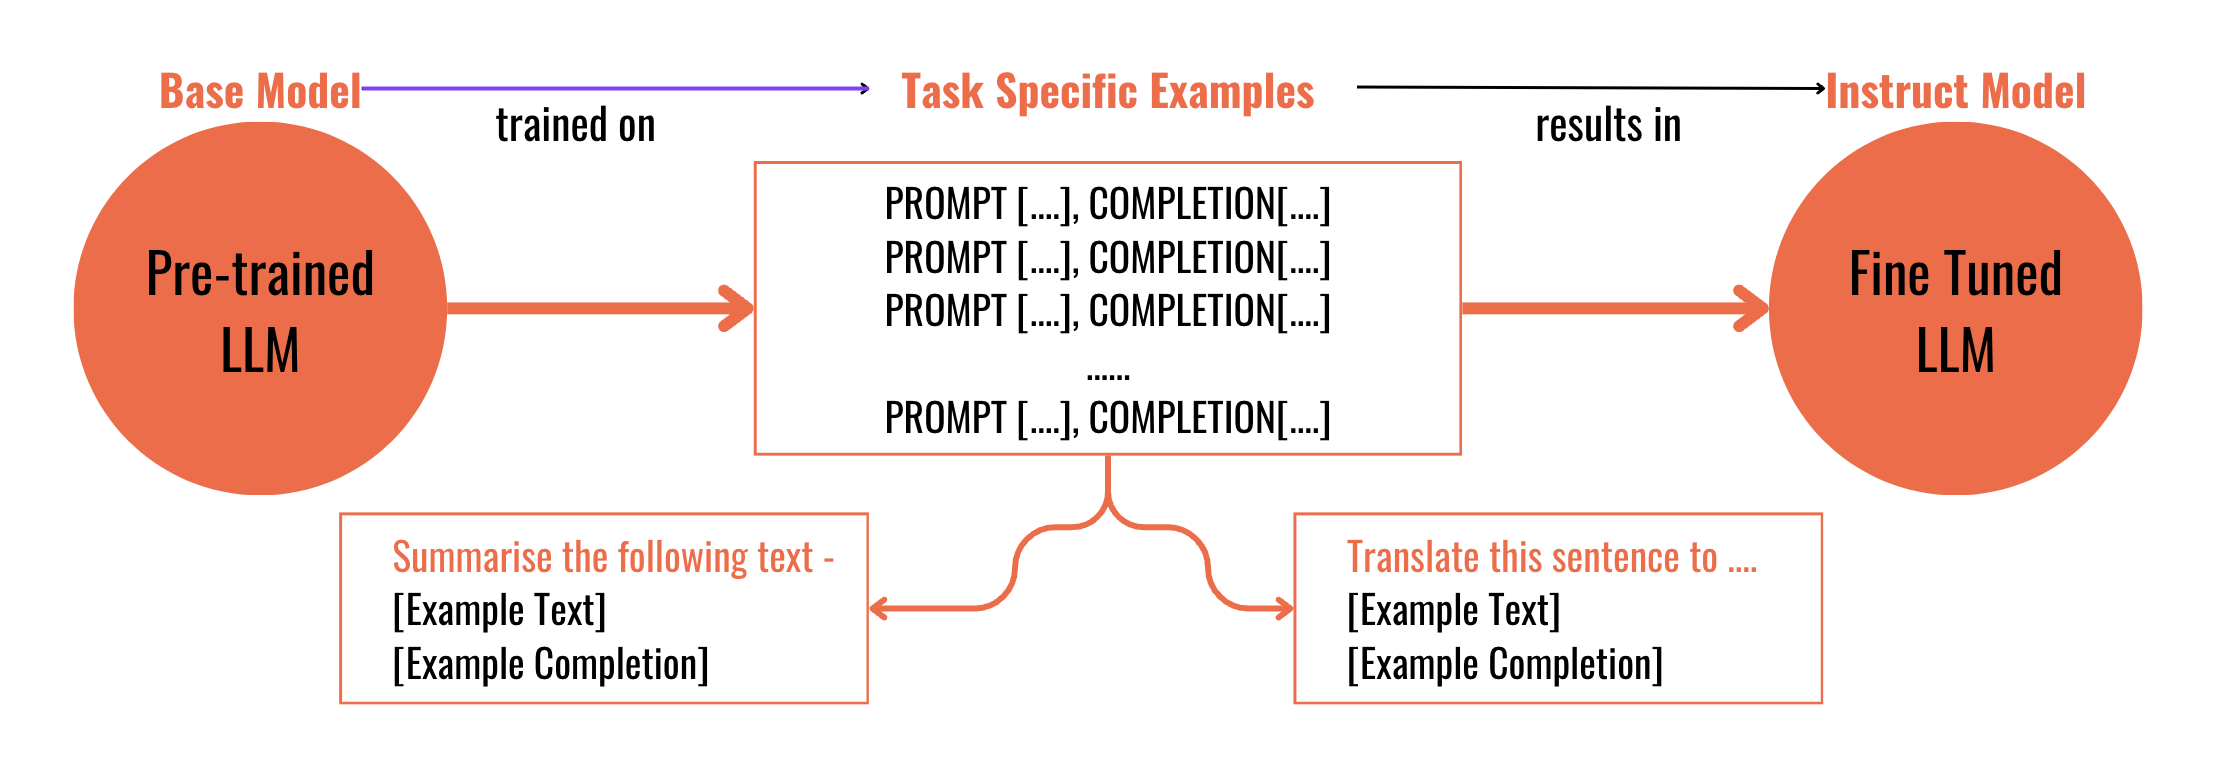

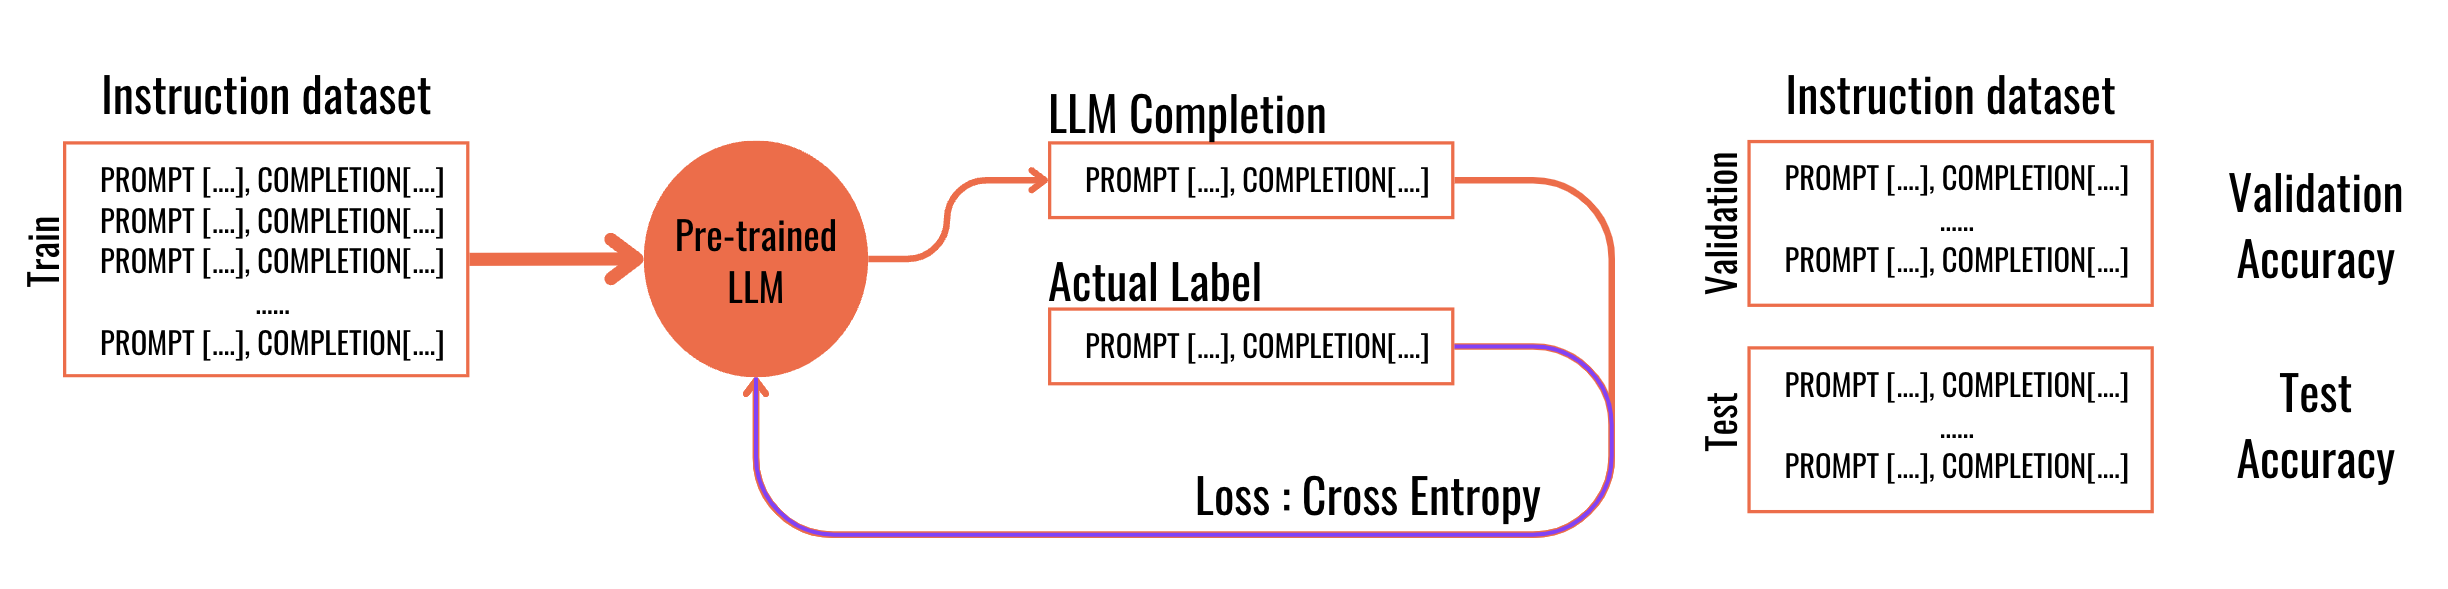

There are three broad steps in LLM finetuning -

1. Data Preparation (for the specific task/use case)
2. Training (chosen training methodology)
3. Evaluation

##### Fine-tuning OpenAI base models

- gpt-3.5-turbo-0613
- babbage-002
- davinci-002

###### Step 1 : Preparing the dataset

**Use Case** - Generate LLM responses in a defined language construct

https://drive.google.com/file/d/1n9iwa7dphWr43Ttbp0uXxhyGGtyFUO3M/view?usp=drive_link

- For babbage-002 and davinci-002 base models

In [ ]:
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}

- for gpt-3.5-turbo-0613 base model

In [ ]:
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [22]:
data_folder_path='../Data/'
training_data_file='fine_tuning_data.csv'

In [23]:
data_for_finetuning=pd.read_csv(data_folder_path+training_data_file)

In [ ]:
data_for_finetuning.head()

In [ ]:
data_for_finetuning.shape

In [ ]:
train_data, test_data = train_test_split(data_for_finetuning, test_size=0.2, random_state=42)

In [ ]:
train_data.shape

In [ ]:
test_data.shape

End of Sequence Token

In [ ]:
prompt_end="<--"
completion_end="-->"

In [ ]:
def convert_data_for_bd(data,file):
  with open(file,'w') as f:
    for _,rows in data.iterrows():
      prompt=rows['prompt']+prompt_end
      completion=rows['completion']+completion_end
      json_line = {"prompt": prompt, "completion": completion}
      f.write(json.dumps(json_line) + '\n')

  print(f'JSONlines file "{file}" has been created.')

In [ ]:
train_file_bd_name='train_bd.jsonl'
test_file_bd_name='test_bd.jsonl'


In [ ]:
convert_data_for_bd(train_data,data_folder_path+train_file_bd_name)
convert_data_for_bd(test_data,data_folder_path+test_file_bd_name)

In [ ]:
openai.File.create(
                file=open(data_folder_path+train_file_bd_name, "rb"),
                purpose='fine-tune'
)

In [ ]:
openai.File.create(
                file=open(data_folder_path+test_file_bd_name, "rb"),
                purpose='fine-tune'
)

###### Step 2 : Training

In [ ]:
openai.FineTuningJob.create(
              training_file="file-KiBdHEFjpLDPZygUmAbMt7jz",
              validation_file="file-d7SfXoBkdnLgTh4g3oHWf2Sa",
              model="davinci-002",
              suffix="AIML-Tutorial",
              hyperparameters={"n_epochs":1}
              )

In [ ]:
openai.FineTuningJob.list()

In [ ]:
openai.FineTuningJob.list_events(id="ftjob-ybFhNJz270olerQXcdXbUleb", limit=2)

###### Repeating step 1 & step 2 for 3.5 Turbo model

In [ ]:
def convert_data_for_turbo(data,file):
  with open(file,'w') as f:
    for _,rows in data.iterrows():
      prompt=rows['prompt']+prompt_end
      completion=rows['completion']+completion_end
      json_line = {'messages': [{'role': 'system',
                                'content': ''},
                                {'role': 'user',
                                 'content': prompt},
                                {'role': 'assistant',
                                'content': completion}]}
      f.write(json.dumps(json_line) + '\n')

  print(f'JSONlines file "{file}" has been created.')

In [ ]:
train_file_turbo_name='train_turbo.jsonl'
test_file_turbo_name='test_turbo.jsonl'

In [ ]:
convert_data_for_turbo(train_data,data_folder_path+train_file_turbo_name)
convert_data_for_turbo(test_data,data_folder_path+test_file_turbo_name)

In [ ]:
openai.File.create(
                file=open(data_folder_path+train_file_turbo_name, "rb"),
                purpose='fine-tune'
)

In [ ]:
openai.File.create(
                file=open(data_folder_path+test_file_turbo_name, "rb"),
                purpose='fine-tune'
)

In [ ]:
openai.FineTuningJob.create(
              training_file="file-ura1xq7Js10JeRdeYRa4ZIv2",
              validation_file="file-vdfOTY3RbI1WLvOsBSwoVEvB",
              model="gpt-3.5-turbo-0613",
              suffix="AIML-Tutorial",
              hyperparameters={"n_epochs":1}
              )

In [ ]:
openai.FineTuningJob.list(limit=2)

In [ ]:
openai.FineTuningJob.list_events(id="ftjob-mLdDXP9ls9eLCugPIBpkN86S", limit=2)

###### Step 3: Evaluation

Example 1

In [ ]:
test_data.iloc[0]["prompt"]

In [ ]:
prompt=str(test_data.iloc[0]["prompt"])+prompt_end

In [ ]:
response=openai.Completion.create(model="ft:davinci-002:yarnit-innovations-pvt-ltd:aiml-tutorial:8AZYai1j",
                                        prompt=prompt,
                                        temperature=0.9,
                                        max_tokens=100,
                                        top_p=1,
                                        frequency_penalty=1,
                                        presence_penalty=1,
                                        user="user_id")

In [ ]:
response.choices[0].text

In [ ]:
response.choices[0].text.split(completion_end)[0]

In [ ]:
test_data.iloc[0]["completion"]

**Example 2**

In [ ]:
topic="Explain server side events"

In [ ]:
prompt=topic+prompt_end

In [ ]:
response=openai.Completion.create(model="ft:davinci-002:yarnit-innovations-pvt-ltd:aiml-tutorial:8AZYai1j",
                                        prompt=prompt,
                                        temperature=0.9,
                                        max_tokens=100,
                                        top_p=.5,
                                        frequency_penalty=.5,
                                        presence_penalty=.5,
                                        user="user_id")

In [ ]:
response.choices[0].text.split(completion_end)[0]

In [ ]:
model="ft:gpt-3.5-turbo-0613:yarnit-innovations-pvt-ltd:aiml-tutorial:8AZkWQyf"

In [ ]:
response=openai.ChatCompletion.create(model=model,
                            messages=[{"role":"user","content":prompt}],
                            temperature=.7,
                            max_tokens=500,
                            top_p=1,
                            frequency_penalty=1,
                            presence_penalty=1,
                            user="tutuser001")

In [ ]:
response.choices[0].message.content.split(completion_end)[0]

##### Fully Fine-tuning an Open Source Model (EleutherAI - pythia-70m)

###### downloading Pythia 70M model from Hugging Face

In [24]:
model_name = "EleutherAI/pythia-70m"

In [25]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

###### downloading the tokenizer

In [26]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

###### tokenization illustration

In [27]:
data_for_finetuning.iloc[0]["prompt"]

'share my knowledge on The Influence Of Typography On Social Media Posts'

In [28]:
tokenizer(data_for_finetuning.iloc[0]["prompt"])

{'input_ids': [18316, 619, 3640, 327, 380, 496, 23718, 4683, 13666, 3756, 1623, 8404, 11263, 36304], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [29]:
encoded_text=tokenizer(data_for_finetuning.iloc[0]["prompt"])["input_ids"]
print(encoded_text)

[18316, 619, 3640, 327, 380, 496, 23718, 4683, 13666, 3756, 1623, 8404, 11263, 36304]


In [30]:
decoded_text = tokenizer.decode(encoded_text)
print(decoded_text)

share my knowledge on The Influence Of Typography On Social Media Posts


###### tokenizing and splitting the entire dataset

In [31]:
def tokenize_function(examples):
    text = str(examples["prompt"][0])+"-->" + str(examples["completion"][0]) + "<--"

    tokenizer.pad_token = tokenizer.eos_token
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        padding=True,
    )

    max_length = min(
        tokenized_inputs["input_ids"].shape[1],
        2048
    )
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=max_length
    )

    return tokenized_inputs

In [32]:
finetuning_dataset_loaded=Dataset.from_pandas(data_for_finetuning)

In [33]:
tokenized_dataset = finetuning_dataset_loaded.map(
    tokenize_function,
    batched=True,
    batch_size=1,
    drop_last_batch=True
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 481/481 [00:00<00:00, 1661.32 examples/s]


In [34]:
print(tokenized_dataset)

Dataset({
    features: ['prompt', 'completion', 'input_ids', 'attention_mask'],
    num_rows: 481
})


In [35]:
tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])

In [36]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, shuffle=True, seed=145)
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 384
    })
    test: Dataset({
        features: ['prompt', 'completion', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 97
    })
})


In [37]:
split_dataset["train"]

Dataset({
    features: ['prompt', 'completion', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 384
})

###### training

In [38]:
device_count = torch.cuda.device_count()
if device_count > 0:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [39]:
base_model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [40]:
from transformers import TrainingArguments, Trainer


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [41]:
OUTPUT_DIR='../Model'

In [59]:
training_args = TrainingArguments(
    # Learning rate
  learning_rate=1.0e-5,

  # Number of training epochs
  num_train_epochs=3,

  # Max steps to train for (each step is a batch of data)
  # Overrides num_train_epochs, if not -1
  max_steps=100,

  # Batch size for training
  per_device_train_batch_size=1,

  # Directory to save model checkpoints
  output_dir=OUTPUT_DIR,

  # Other arguments
  overwrite_output_dir=False, # Overwrite the content of the output directory
  disable_tqdm=False, # Disable progress bars
  eval_steps=10, # Number of update steps between two evaluations
  save_steps=20, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=1, # Batch size for evaluation
  evaluation_strategy="steps",
  logging_strategy="steps",
  logging_steps=1,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,

  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)


In [60]:
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],

)


In [61]:
trainer.train()

                                      
  0%|          | 0/10 [01:29<?, ?it/s]         

{'loss': 5.1514, 'learning_rate': 1e-05, 'epoch': 0.01}


                                      
  0%|          | 0/10 [01:30<?, ?it/s]         

{'loss': 5.4094, 'learning_rate': 9.8989898989899e-06, 'epoch': 0.02}


                                      
  0%|          | 0/10 [01:30<?, ?it/s]         

{'loss': 5.215, 'learning_rate': 9.797979797979798e-06, 'epoch': 0.03}


                                      
  0%|          | 0/10 [01:31<?, ?it/s]         

{'loss': 4.4632, 'learning_rate': 9.696969696969698e-06, 'epoch': 0.04}


                                      
  0%|          | 0/10 [01:31<?, ?it/s]         

{'loss': 3.7645, 'learning_rate': 9.595959595959597e-06, 'epoch': 0.05}


                                      
  0%|          | 0/10 [01:32<?, ?it/s]         

{'loss': 3.8817, 'learning_rate': 9.494949494949497e-06, 'epoch': 0.06}


                                      
  0%|          | 0/10 [01:32<?, ?it/s]         

{'loss': 3.4736, 'learning_rate': 9.393939393939396e-06, 'epoch': 0.07}


                                      
  0%|          | 0/10 [01:33<?, ?it/s]         

{'loss': 3.3642, 'learning_rate': 9.292929292929294e-06, 'epoch': 0.08}


                                      
  0%|          | 0/10 [01:33<?, ?it/s]         

{'loss': 4.0707, 'learning_rate': 9.191919191919193e-06, 'epoch': 0.09}


                                      
  0%|          | 0/10 [01:34<?, ?it/s]          

{'loss': 4.2151, 'learning_rate': 9.090909090909091e-06, 'epoch': 0.1}


                                      
  0%|          | 0/10 [01:34<?, ?it/s]          

{'loss': 2.9339, 'learning_rate': 8.98989898989899e-06, 'epoch': 0.11}


                                      
  0%|          | 0/10 [01:35<?, ?it/s]          

{'loss': 3.0065, 'learning_rate': 8.888888888888888e-06, 'epoch': 0.12}


                                      
  0%|          | 0/10 [01:35<?, ?it/s]          

{'loss': 3.5464, 'learning_rate': 8.787878787878788e-06, 'epoch': 0.14}


                                      
  0%|          | 0/10 [01:35<?, ?it/s]          

{'loss': 2.6889, 'learning_rate': 8.686868686868687e-06, 'epoch': 0.15}


                                      
  0%|          | 0/10 [01:36<?, ?it/s]          

{'loss': 2.28, 'learning_rate': 8.585858585858587e-06, 'epoch': 0.16}


                                      
  0%|          | 0/10 [01:36<?, ?it/s]          

{'loss': 2.0646, 'learning_rate': 8.484848484848486e-06, 'epoch': 0.17}


                                      
  0%|          | 0/10 [01:37<?, ?it/s]          

{'loss': 3.195, 'learning_rate': 8.383838383838384e-06, 'epoch': 0.18}


                                      
  0%|          | 0/10 [01:37<?, ?it/s]          

{'loss': 2.4569, 'learning_rate': 8.282828282828283e-06, 'epoch': 0.19}


                                      
  0%|          | 0/10 [01:38<?, ?it/s]          

{'loss': 2.8936, 'learning_rate': 8.181818181818183e-06, 'epoch': 0.2}


                                      
  0%|          | 0/10 [01:38<?, ?it/s]          

{'loss': 2.1597, 'learning_rate': 8.08080808080808e-06, 'epoch': 0.21}


                                      
  0%|          | 0/10 [01:39<?, ?it/s]          

{'loss': 1.8646, 'learning_rate': 7.97979797979798e-06, 'epoch': 0.22}


                                      
  0%|          | 0/10 [01:39<?, ?it/s]          

{'loss': 2.8396, 'learning_rate': 7.87878787878788e-06, 'epoch': 0.23}


                                      
  0%|          | 0/10 [01:40<?, ?it/s]          

{'loss': 1.842, 'learning_rate': 7.77777777777778e-06, 'epoch': 0.24}


                                      
  0%|          | 0/10 [01:40<?, ?it/s]          

{'loss': 2.7278, 'learning_rate': 7.676767676767677e-06, 'epoch': 0.25}


                                      
  0%|          | 0/10 [01:41<?, ?it/s]          

{'loss': 2.0696, 'learning_rate': 7.5757575757575764e-06, 'epoch': 0.26}


                                      
  0%|          | 0/10 [01:41<?, ?it/s]          

{'loss': 1.8703, 'learning_rate': 7.474747474747476e-06, 'epoch': 0.27}


                                      
  0%|          | 0/10 [01:42<?, ?it/s]          

{'loss': 2.2032, 'learning_rate': 7.373737373737374e-06, 'epoch': 0.28}


                                      
  0%|          | 0/10 [01:42<?, ?it/s]          

{'loss': 1.8623, 'learning_rate': 7.272727272727273e-06, 'epoch': 0.29}


                                      
  0%|          | 0/10 [01:43<?, ?it/s]          

{'loss': 1.7798, 'learning_rate': 7.171717171717172e-06, 'epoch': 0.3}


                                      
  0%|          | 0/10 [01:43<?, ?it/s]          

{'loss': 1.7268, 'learning_rate': 7.070707070707071e-06, 'epoch': 0.31}


                                      
  0%|          | 0/10 [01:44<?, ?it/s]          

{'loss': 1.7228, 'learning_rate': 6.969696969696971e-06, 'epoch': 0.32}


                                      
  0%|          | 0/10 [01:44<?, ?it/s]          

{'loss': 1.8869, 'learning_rate': 6.868686868686869e-06, 'epoch': 0.33}


                                      
  0%|          | 0/10 [01:45<?, ?it/s]          

{'loss': 1.8074, 'learning_rate': 6.767676767676769e-06, 'epoch': 0.34}


                                      
  0%|          | 0/10 [01:45<?, ?it/s]          

{'loss': 1.9418, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.35}


                                      
  0%|          | 0/10 [01:45<?, ?it/s]          

{'loss': 1.3157, 'learning_rate': 6.565656565656566e-06, 'epoch': 0.36}


                                      
  0%|          | 0/10 [01:46<?, ?it/s]          

{'loss': 1.4374, 'learning_rate': 6.464646464646466e-06, 'epoch': 0.38}


                                      
  0%|          | 0/10 [01:46<?, ?it/s]          

{'loss': 1.9445, 'learning_rate': 6.363636363636364e-06, 'epoch': 0.39}


                                      
  0%|          | 0/10 [01:47<?, ?it/s]          

{'loss': 1.7828, 'learning_rate': 6.262626262626264e-06, 'epoch': 0.4}


                                      
  0%|          | 0/10 [01:47<?, ?it/s]          

{'loss': 1.3831, 'learning_rate': 6.1616161616161615e-06, 'epoch': 0.41}


                                      
  0%|          | 0/10 [01:48<?, ?it/s]          

{'loss': 1.438, 'learning_rate': 6.060606060606061e-06, 'epoch': 0.42}


                                      
  0%|          | 0/10 [01:48<?, ?it/s]          

{'loss': 1.0242, 'learning_rate': 5.95959595959596e-06, 'epoch': 0.43}


                                      
  0%|          | 0/10 [01:49<?, ?it/s]          

{'loss': 1.0181, 'learning_rate': 5.858585858585859e-06, 'epoch': 0.44}


                                      
  0%|          | 0/10 [01:49<?, ?it/s]          

{'loss': 1.2453, 'learning_rate': 5.7575757575757586e-06, 'epoch': 0.45}


                                      
  0%|          | 0/10 [01:50<?, ?it/s]          

{'loss': 0.9993, 'learning_rate': 5.656565656565657e-06, 'epoch': 0.46}


                                      
  0%|          | 0/10 [01:50<?, ?it/s]          

{'loss': 2.7724, 'learning_rate': 5.555555555555557e-06, 'epoch': 0.47}


                                      
  0%|          | 0/10 [01:51<?, ?it/s]          

{'loss': 1.2194, 'learning_rate': 5.4545454545454545e-06, 'epoch': 0.48}


                                      
  0%|          | 0/10 [01:51<?, ?it/s]          

{'loss': 1.6967, 'learning_rate': 5.353535353535354e-06, 'epoch': 0.49}


                                      
  0%|          | 0/10 [01:52<?, ?it/s]          

{'loss': 3.0026, 'learning_rate': 5.252525252525253e-06, 'epoch': 0.5}


                                      
  0%|          | 0/10 [01:52<?, ?it/s]          

{'loss': 1.6234, 'learning_rate': 5.151515151515152e-06, 'epoch': 0.51}


                                      
  0%|          | 0/10 [01:53<?, ?it/s]          

{'loss': 0.9972, 'learning_rate': 5.0505050505050515e-06, 'epoch': 0.52}


                                      
  0%|          | 0/10 [01:53<?, ?it/s]          

{'loss': 1.5477, 'learning_rate': 4.94949494949495e-06, 'epoch': 0.53}


                                      
  0%|          | 0/10 [01:54<?, ?it/s]          

{'loss': 0.7842, 'learning_rate': 4.848484848484849e-06, 'epoch': 0.54}


                                      
  0%|          | 0/10 [01:54<?, ?it/s]          

{'loss': 1.1416, 'learning_rate': 4.747474747474748e-06, 'epoch': 0.55}


                                      
  0%|          | 0/10 [01:55<?, ?it/s]          

{'loss': 2.0697, 'learning_rate': 4.646464646464647e-06, 'epoch': 0.56}


                                      
  0%|          | 0/10 [01:55<?, ?it/s]          

{'loss': 0.7819, 'learning_rate': 4.5454545454545455e-06, 'epoch': 0.57}


                                      
  0%|          | 0/10 [01:56<?, ?it/s]          

{'loss': 1.2613, 'learning_rate': 4.444444444444444e-06, 'epoch': 0.58}


                                      
  0%|          | 0/10 [01:56<?, ?it/s]          

{'loss': 2.1898, 'learning_rate': 4.343434343434344e-06, 'epoch': 0.59}


                                      
  0%|          | 0/10 [01:57<?, ?it/s]          

{'loss': 1.5984, 'learning_rate': 4.242424242424243e-06, 'epoch': 0.6}


                                      
  0%|          | 0/10 [01:57<?, ?it/s]          

{'loss': 0.9041, 'learning_rate': 4.141414141414142e-06, 'epoch': 0.61}


                                      
  0%|          | 0/10 [01:58<?, ?it/s]          

{'loss': 2.0469, 'learning_rate': 4.04040404040404e-06, 'epoch': 0.62}





































                                               
                                             
  0%|          | 0/10 [02:02<?, ?it/s]


{'eval_loss': 1.1732226610183716, 'eval_runtime': 3.9857, 'eval_samples_per_second': 24.337, 'eval_steps_per_second': 24.337, 'epoch': 0.62}


                                      
  0%|          | 0/10 [02:02<?, ?it/s]          

{'loss': 0.6047, 'learning_rate': 3.93939393939394e-06, 'epoch': 0.64}


                                      
  0%|          | 0/10 [02:03<?, ?it/s]          

{'loss': 0.9034, 'learning_rate': 3.8383838383838385e-06, 'epoch': 0.65}


                                      
  0%|          | 0/10 [02:03<?, ?it/s]          

{'loss': 2.2783, 'learning_rate': 3.737373737373738e-06, 'epoch': 0.66}


                                      
  0%|          | 0/10 [02:04<?, ?it/s]          

{'loss': 2.1779, 'learning_rate': 3.6363636363636366e-06, 'epoch': 0.67}


                                      
  0%|          | 0/10 [02:04<?, ?it/s]          

{'loss': 1.1455, 'learning_rate': 3.5353535353535356e-06, 'epoch': 0.68}


                                      
  0%|          | 0/10 [02:05<?, ?it/s]          

{'loss': 0.8096, 'learning_rate': 3.4343434343434347e-06, 'epoch': 0.69}


                                      
  0%|          | 0/10 [02:05<?, ?it/s]          

{'loss': 1.7393, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.7}


                                      
  0%|          | 0/10 [02:06<?, ?it/s]          

{'loss': 1.6709, 'learning_rate': 3.232323232323233e-06, 'epoch': 0.71}


                                      
  0%|          | 0/10 [02:06<?, ?it/s]          

{'loss': 2.0467, 'learning_rate': 3.131313131313132e-06, 'epoch': 0.72}


                                      
  0%|          | 0/10 [02:07<?, ?it/s]          

{'loss': 1.6481, 'learning_rate': 3.0303030303030305e-06, 'epoch': 0.73}


                                      
  0%|          | 0/10 [02:07<?, ?it/s]          

{'loss': 0.5566, 'learning_rate': 2.9292929292929295e-06, 'epoch': 0.74}


                                      
  0%|          | 0/10 [02:08<?, ?it/s]          

{'loss': 0.6924, 'learning_rate': 2.8282828282828286e-06, 'epoch': 0.75}


                                      
  0%|          | 0/10 [02:08<?, ?it/s]          

{'loss': 1.5795, 'learning_rate': 2.7272727272727272e-06, 'epoch': 0.76}


                                      
  0%|          | 0/10 [02:09<?, ?it/s]          

{'loss': 1.0132, 'learning_rate': 2.6262626262626267e-06, 'epoch': 0.77}


                                      
  0%|          | 0/10 [02:09<?, ?it/s]          

{'loss': 0.6103, 'learning_rate': 2.5252525252525258e-06, 'epoch': 0.78}


                                      
  0%|          | 0/10 [02:10<?, ?it/s]          

{'loss': 0.9741, 'learning_rate': 2.4242424242424244e-06, 'epoch': 0.79}


                                      
  0%|          | 0/10 [02:10<?, ?it/s]          

{'loss': 3.4148, 'learning_rate': 2.3232323232323234e-06, 'epoch': 0.8}


                                      
  0%|          | 0/10 [02:11<?, ?it/s]          

{'loss': 0.5637, 'learning_rate': 2.222222222222222e-06, 'epoch': 0.81}


                                      
  0%|          | 0/10 [02:11<?, ?it/s]          

{'loss': 1.7004, 'learning_rate': 2.1212121212121216e-06, 'epoch': 0.82}


                                      
  0%|          | 0/10 [02:12<?, ?it/s]          

{'loss': 0.5242, 'learning_rate': 2.02020202020202e-06, 'epoch': 0.83}


                                      
  0%|          | 0/10 [02:12<?, ?it/s]          

{'loss': 1.2696, 'learning_rate': 1.9191919191919192e-06, 'epoch': 0.84}


                                      
  0%|          | 0/10 [02:13<?, ?it/s]          

{'loss': 1.7076, 'learning_rate': 1.8181818181818183e-06, 'epoch': 0.85}


                                      
  0%|          | 0/10 [02:13<?, ?it/s]          

{'loss': 1.6407, 'learning_rate': 1.7171717171717173e-06, 'epoch': 0.86}


                                      
  0%|          | 0/10 [02:14<?, ?it/s]          

{'loss': 0.5297, 'learning_rate': 1.6161616161616164e-06, 'epoch': 0.88}


                                      
  0%|          | 0/10 [02:14<?, ?it/s]          

{'loss': 1.3491, 'learning_rate': 1.5151515151515152e-06, 'epoch': 0.89}


                                      
  0%|          | 0/10 [02:14<?, ?it/s]          

{'loss': 0.9191, 'learning_rate': 1.4141414141414143e-06, 'epoch': 0.9}


                                      
  0%|          | 0/10 [02:15<?, ?it/s]          

{'loss': 1.4463, 'learning_rate': 1.3131313131313134e-06, 'epoch': 0.91}


                                      
  0%|          | 0/10 [02:15<?, ?it/s]          

{'loss': 0.7706, 'learning_rate': 1.2121212121212122e-06, 'epoch': 0.92}


                                      
  0%|          | 0/10 [02:16<?, ?it/s]          

{'loss': 0.9417, 'learning_rate': 1.111111111111111e-06, 'epoch': 0.93}


                                      
  0%|          | 0/10 [02:16<?, ?it/s]          

{'loss': 1.3359, 'learning_rate': 1.01010101010101e-06, 'epoch': 0.94}


                                      
  0%|          | 0/10 [02:17<?, ?it/s]          

{'loss': 1.0156, 'learning_rate': 9.090909090909091e-07, 'epoch': 0.95}


                                      
  0%|          | 0/10 [02:17<?, ?it/s]          

{'loss': 2.2845, 'learning_rate': 8.080808080808082e-07, 'epoch': 0.96}


                                      
  0%|          | 0/10 [02:18<?, ?it/s]          

{'loss': 1.9543, 'learning_rate': 7.070707070707071e-07, 'epoch': 0.97}


                                      
  0%|          | 0/10 [02:18<?, ?it/s]          

{'loss': 0.4897, 'learning_rate': 6.060606060606061e-07, 'epoch': 0.98}


                                      
  0%|          | 0/10 [02:19<?, ?it/s]          

{'loss': 0.9549, 'learning_rate': 5.05050505050505e-07, 'epoch': 0.99}


                                      
  0%|          | 0/10 [02:19<?, ?it/s]          

{'loss': 0.9248, 'learning_rate': 4.040404040404041e-07, 'epoch': 1.0}


                                      
  0%|          | 0/10 [02:19<?, ?it/s]          

{'loss': 0.8856, 'learning_rate': 3.0303030303030305e-07, 'epoch': 1.01}


                                      
  0%|          | 0/10 [02:20<?, ?it/s]          

{'loss': 1.4476, 'learning_rate': 2.0202020202020205e-07, 'epoch': 1.02}


                                      
  0%|          | 0/10 [02:20<?, ?it/s]          

{'loss': 1.1553, 'learning_rate': 1.0101010101010103e-07, 'epoch': 1.03}


                                      
                                                 
100%|██████████| 100/100 [00:52<00:00,  1.91it/s]

{'loss': 0.9411, 'learning_rate': 0.0, 'epoch': 1.04}
{'train_runtime': 52.3579, 'train_samples_per_second': 7.64, 'train_steps_per_second': 1.91, 'train_loss': 1.8822158247232437, 'epoch': 1.04}


TrainOutput(global_step=100, training_loss=1.8822158247232437, metrics={'train_runtime': 52.3579, 'train_samples_per_second': 7.64, 'train_steps_per_second': 1.91, 'train_loss': 1.8822158247232437, 'epoch': 1.04})

In [62]:
save_dir = OUTPUT_DIR+"/final_model"

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

Saved model to: ../Model/final_model


In [63]:
finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)

In [64]:
finetuned_slightly_model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

###### Generating text from the model

In [65]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )




  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )



  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)




  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text)+3:].split("<--")[0]

  return generated_text_answer

In [66]:
inference("share information about data science", finetuned_slightly_model, tokenizer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


"Data science may be underestimated, but it's a valuable resource for understanding and understanding the future of health information and health information"

In [67]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

In [68]:
inference("share information about Benefits Of Mindfulness Meditation", base_model, tokenizer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


'The study was conducted in the UK in the UK in the summer of 2014. The study was conducted in the UK in the summer of 2014. The study was conducted in the UK in the summer of 2014. The study was conducted in the UK in the summer of 2014. The study was conducted in the UK in the summer of 2014. The study was conducted in the summer of 2014. The study was conducted in the summer of 2014.'

# Contact

- [email](abhinav.kimothi.ds@gmail.com)

- [LinkedIn](https://www.linkedin.com/in/abhinav-kimothi/)

- [Github Repo](https://github.com/abhinav-kimothi/RAG-and-Fine-Tuning)
